# Matching studies to grid cells via shapes

[![colab badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mcallaghan/NLP-climate-science-tutorial-CCAI/blob/main/G_match_studies_gridcells.ipynb)

The output of our geoparser gives us locations with a latitude and longitude of the center of each place.
This information already allows us to map our results, but doing this with this information can be misleading. 

Some geographical entities are very large, so plotting a point in the center of them may not be the best way to represent the information. Further, if we want to bring this data together with other information about the world, for example climate model data, we need a common geographical unit.

For this we can use grid cells, which divide the world into equally sized (in terms of geographical coordinates but not in terms of area) cells. Via shapefiles, which translate the places we have into our database into a polygon rather than a simple point, we can map our places we found in the studies to gridcells

In [1]:
# First we load our location data and drop any duplicated places within documents
import pandas as pd

import os
## If we are running in colab, mount google drive and change into the directory we cloned the repository into
if os.path.exists("/content/"):
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/NLP-climate-science-tutorial-CCAI") 

# Load location data 
places = pd.read_csv('data/combined_place_df.csv')                                                                                                                                                                                                                                                                                                                                                                                                                              
places = places.drop_duplicates(["doc_id","geonameid"]) 

### Coordinate grids

Coordinate systems split the world up into 360 degrees of longitude (from 180° West to 180° East), and 180 degrees of latitude (from 90° South to 90° North). We can set up a grid like this with cells of a given size in degrees with numpy.

In [2]:
import numpy as np
def generate_grid_df(degrees):
    '''
    Generate a dataframe with a grid of of cells degrees x degrees
    '''
    LON = np.linspace(-180+degrees*0.5,180-degrees*0.5,int(360/degrees))
    LAT = np.linspace(-90+degrees*0.5,90-degrees*0.5,int(180/degrees))
    lon_df, lat_df = np.meshgrid(LON,LAT)

    return pd.DataFrame({"LAT": lat_df.ravel(), "LON": lon_df.ravel()})
    
grid_df = generate_grid_df(2.5)
grid_df.head()

,LAT,LON
0,-88.75,-178.75
1,-88.75,-176.25
2,-88.75,-173.75
3,-88.75,-171.25
4,-88.75,-168.75


It often helps to do a quick sanity check of this grid by merging it with some other gridded data and plotting

<ipython-input-3-db5c2375e64c>:25: RuntimeWarning: divide by zero encountered in log
  n = np.log(np.array(pop_grid_df.population)).reshape(shape)


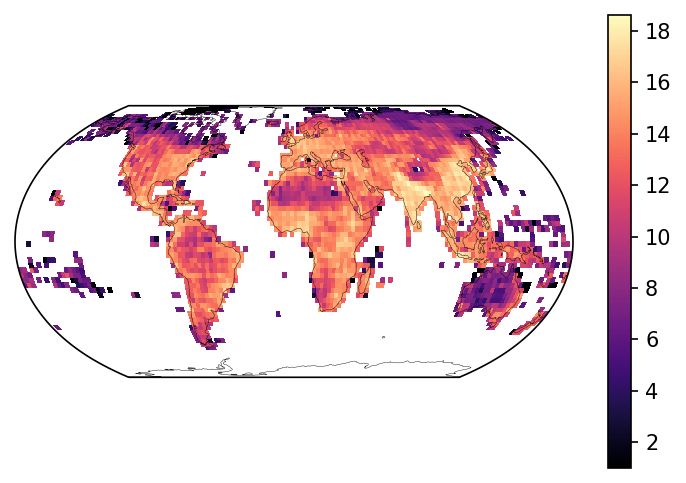

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rioxarray


fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.2)

# We will open some population data
rds = rioxarray.open_rasterio("data/gpw_v4_population_count_rev11_2020_1_deg.asc")
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "population"
pop_df = rds.to_dataframe().reset_index()

# We can round the grid points up to the grid cell size we have
pop_df['LAT'] = pop_df['y']//2.5*2.5+1.25
pop_df['LON'] = pop_df['x']//2.5*2.5+1.25
pop_df.loc[pop_df['population'].isin([-9999,0]),"population"]=np.NaN
# And take the sum of each of these larger grid cells
pop_df = pop_df.groupby(["LAT","LON"])['population'].sum().reset_index()

pop_grid_df = grid_df.merge(pop_df, how="left")
shape = (len(grid_df.LAT.unique()), len(grid_df.LON.unique()))
n = np.log(np.array(pop_grid_df.population)).reshape(shape)

mesh=ax.pcolormesh(
    grid_df.LON.unique(), 
    grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    vmin=1,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

it seems to work!

## Shapefiles

To bridge between our places and our grid cells, we need to get shape files that will give us polygons for the various geographical entities we have. Below is list of cultural and physical shapefiles from [Natural Earth](https://www.naturalearthdata.com/) which cover many of the larger feature types we have

In [4]:
import cartopy.io.shapereader as shpreader
import geopandas
# First we define a list of the shapefile definitions we want
shpfiles = [
    dict(resolution='50m', category='cultural', name='admin_0_countries'),
    dict(resolution='10m', category='cultural', name='admin_1_states_provinces'),
    dict(resolution='10m', category='physical', name='geography_regions_polys'),
    dict(resolution='10m', category='physical', name='geography_marine_polys')
    #"data/gadm36_1.shp"
]

In [5]:
import shapely.vectorized
import warnings
import time


def match_shp_grid(shpfiles, grid_df, shp_grid_df, degrees):
    # Now we download the shapefiles and combine into one large geopandas dataframe
    shp_df  = None
    for shpfilename in shpfiles:
        print(f"reading shapefile {shpfilename}")
        if shp_df is None:
            shp_df = geopandas.read_file(shpreader.natural_earth(**shpfilename))
        else:
            shp_df = shp_df.merge(geopandas.read_file(shpreader.natural_earth(**shpfilename)),how="outer")
        time.sleep(10) # Wait a bit before downloading the next shapefile so we do not make too many requests too quickly
    
    # We are going to store our shapefile-gridcell index matches here
    shp_grid = []

    # This is the grid we will work with
    yv, xv = np.meshgrid(grid_df.LAT.unique(), grid_df.LON.unique())
    for i, place in shp_df.iterrows(): # Now we go through all the shapes
        # show which gridcell centers are contained inside the shape
        # ignore the warning caused by shapely using an old version of numpy
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            inplace = shapely.vectorized.contains(place.geometry, xv, yv)
        idx = np.argwhere(inplace)
        # Get the number of cells contained in the shape
        number_cells = idx.size/2
        if number_cells == 0:
            # If we have no cell centers in the shape, get the shape center and the cell which contains it
            c = np.array(place.geometry.centroid)
            lon = c[0]//degrees*degrees+degrees*0.5
            lat = c[1]//degrees*degrees+degrees*0.5
            da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
            shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]})
        else:
            for point in idx:
                lon = grid_df.LON.unique()[point[0]]
                lat = grid_df.LAT.unique()[point[1]]
                da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
                shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]}) 

    shp_grid_df = pd.DataFrame.from_dict(shp_grid)

    return shp_df, shp_grid_df 

# We'll start an empty dataframe to store our shapefile-grid matches
shp_grid_df = pd.DataFrame()
    
shp_df, shp_grid_df = match_shp_grid(shpfiles, grid_df, shp_grid_df, 2.5)

shp_grid_df.head()

reading shapefile {'resolution': '50m', 'category': 'cultural', 'name': 'admin_0_countries'}
reading shapefile {'resolution': '10m', 'category': 'cultural', 'name': 'admin_1_states_provinces'}
reading shapefile {'resolution': '10m', 'category': 'physical', 'name': 'geography_regions_polys'}
reading shapefile {'resolution': '10m', 'category': 'physical', 'name': 'geography_marine_polys'}


,shpfile_id,grid_df_id
0,0,4114
1,0,3971
2,0,4115
3,0,3972
4,0,4116


The shapefiles from natural earth have different feature classes to the geographical entities in our dataset. The dictionary below maps our place classes to the shapefile classes

In [6]:
places[places["feature_code"]=="PCLI"]

,word,spans,country_predicted,country_conf,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,India,"[{'start': 1558, 'end': 1563}]",IND,0.699107,NaN,22.00000,79.00000,IND,1269750.0,Republic of India,A,PCLI,413349.0
1,Myanmar,"[{'start': 1568, 'end': 1575}]",MMR,0.953179,NaN,21.00000,96.00000,MMR,1327865.0,Union of Burma,A,PCLI,413349.0
15,Germany,"[{'start': 99, 'end': 106}]",DEU,0.946707,NaN,51.50000,10.50000,DEU,2921044.0,Federal Republic of Germany,A,PCLI,1293885.0
74,United States,"[{'start': 322, 'end': 335}]",USA,0.951695,NaN,39.76000,-98.50000,USA,6252001.0,United States,A,PCLI,405676.0
105,India,"[{'start': 373, 'end': 378}]",IND,0.699107,NaN,22.00000,79.00000,IND,1269750.0,Republic of India,A,PCLI,2354931.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44042,Great Britain,"[{'start': 446, 'end': 459}]",GBR,0.951695,NaN,54.75844,-2.69531,GBR,2635167.0,United Kingdom of Great Britain and Northern I...,A,PCLI,https://openalex.org/W2174393891
44060,east Africa,"[{'start': 35, 'end': 46}]",MOZ,0.813797,NaN,-18.25000,35.00000,MOZ,1036973.0,Republic of Mozambique,A,PCLI,https://openalex.org/W1639399916
44062,Kenya,"[{'start': 563, 'end': 568}]",KEN,0.951695,NaN,1.00000,38.00000,KEN,192950.0,Republic of Kenya,A,PCLI,https://openalex.org/W1639399916
44068,India,"[{'start': 110, 'end': 115}]",IND,0.665504,NaN,22.00000,79.00000,IND,1269750.0,Republic of India,A,PCLI,https://openalex.org/W2025163712


In [7]:
shpfile_keys = ["Admin-0 country"]
feature_shapes = shp_df.loc[shp_df["featurecla"].isin(shpfile_keys)]
feature_shapes

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,name_sv,name_tr,name_vi,name_zh,ne_id,namealt,subregion,label,wdid_score,changed
0,Admin-0 country,1,3.0,Zimbabwe,ZWE,0.0,2.0,Sovereign country,Zimbabwe,ZWE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Admin-0 country,1,3.0,Zambia,ZMB,0.0,2.0,Sovereign country,Zambia,ZMB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Admin-0 country,1,3.0,Yemen,YEM,0.0,2.0,Sovereign country,Yemen,YEM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Admin-0 country,3,2.0,Vietnam,VNM,0.0,2.0,Sovereign country,Vietnam,VNM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Admin-0 country,5,3.0,Venezuela,VEN,0.0,2.0,Sovereign country,Venezuela,VEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Admin-0 country,1,6.0,Albania,ALB,0.0,2.0,Sovereign country,Albania,ALB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,Admin-0 country,1,3.0,Afghanistan,AFG,0.0,2.0,Sovereign country,Afghanistan,AFG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,Admin-0 country,1,5.0,Kashmir,KAS,0.0,2.0,Indeterminate,Siachen Glacier,KAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,Admin-0 country,3,4.0,Antarctica,ATA,0.0,2.0,Indeterminate,Antarctica,ATA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
feature_mapping = {
#     "ADM1": ["Admin-1 scale rank", "Admin-1 aggregation", "Admin-1 minor island"],
    "PCLI": ["Admin-0 country"],
#     'MTS': ['Range/mtn'],
#     'PLAT': ['Plateau'],
#     'PLN': ['Plain'],
#     'DSRT': ['Desert'],
#     'OCN': ['ocean'],
#     'SEA': ['sea', 'bay'],
#     'GULF': ['gulf', 'bay'],
#     'BAY': ['gulf', 'bay'],
#     'CHN': ['channel'],
#     'BSNU': ['basin']
}

In [9]:
# We add all the other codes we don't cover with blank shapefile classes
for fcode in places.feature_code.unique():
    if fcode not in feature_mapping:
        feature_mapping[fcode] = []


In [10]:
# To help match, we will rename some shapes so that they are the same as the name in our database
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Altay", case=False)),"name"] = "Altay"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Appalach", case=False)),"name"] = "Appalachian Mountains"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("cant", case=False)),"name"] = "Cordillera Cantábrica"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Dabie", case=False)),"name"] = "Dabie Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("EASTERN GHATS", case=False)),"name"] = "Eastern Ghāts"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("WESTERN GHATS", case=False)),"name"] = "Western Ghāts"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("kunlun", case=False)),"name"] = "Kalakunlun Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("LEN MOUNTAIN", case=False)),"name"] = "Kölen"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Taihang Mts.", case=False)),"name"] = "Taihang Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Tatra Mts.", case=False)),"name"] = "Tatry"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("TIAN SHAN", case=False)),"name"] = "Tien Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("andes", case=False)),"name"] = "Andes Mountains"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("HINDU KUSH", case=False)),"name"] = "Hindū Kush"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Marrah Mts", case=False)),"name"] = "Jabal Marrah"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Lebanon", case=False)),"name"] = "Mount Lebanon"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("KARAKORAM RA", case=False)),"name"] = "Karakorum Shan"

shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Negev", case=False)), "name"] = "Negev"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Atacama", case=False)), "name"] = "Atacama Desert"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("CHIHUAHUAN DESERT", case=False)), "name"] = "Chihuahua Desert"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Lut desert", case=False)), "name"] = "God-e Lut"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("TAKLIMAKAN DESERT", case=False)), "name"] = "Takla Makan Desert"

shp_df.loc[
    (shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("cumberland", case=False)),["name","featurecla"]
] = ["Cumberland Plateau", "Plain"]
shp_df.loc[
    (shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("colorado", case=False)),["name","featurecla"]
] = ["San Francisco Plateau", "Plain"]
shp_df.loc[(shp_df["featurecla"]=="Plain") & (shp_df["name"].str.contains("gange", case=False)),"name"] = "Gangetic Plain"
shp_df.loc[(shp_df["featurecla"]=="Plain") & (shp_df["name"].str.contains("north china", case=False)),"name"] = "Huanghuai Pingyuan"

shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("mongol", case=False)), "name"] = "Nei Mongol Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("deccan", case=False)), "name"] = "Deccan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("chota", case=False)), "name"] = "Chota Nāgpur Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("loess", case=False)), "name"] = "Huangtu Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("khorat", case=False)), "name"] = "Khorat Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("tibet", case=False)), "name"] = "Qing Zang Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("polar", case=False)), "name"] = "South Polar Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("YUNGUI", case=False)), "name"] = "Yungui Gaoyuan"

places["place_name"] = places["place_name"].str.lower().str.replace("mts.","mountains") 
shp_df["name"] = shp_df["name"].str.lower().str.replace("mts.","mountains") 



In [11]:
# We'll start off with an empty dataframe
shp_df_matches = pd.DataFrame()

# And define the grid box size
degrees = 2.5

# Now we want to look through the feature type dictionary we had before
for place_key, shpfile_keys in feature_mapping.items():
    
    # We can get all the places and all the shapes
    feature_places = places.loc[places["feature_code"]==place_key]
    feature_shapes = shp_df.loc[shp_df["featurecla"].isin(shpfile_keys)]
    
    # And loop through the places
    for place, group in feature_places.groupby("place_name"):
        # If we don't have a shapefile feature type we just take the grid cell containing the point
        if not shpfile_keys:
            shp_id = None # we set shp_id to None, round the coordinates, and take the gridcell which has these coordinates
            lon = group.lon.values[0]//degrees*degrees+degrees*0.5
            lat = group.lat.values[0]//degrees*degrees+degrees*0.5
            grid_df_ids = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)].index

        else:
            # Otherwise, we are going to try to find the places which match
            place_shapes = pd.DataFrame()
            # First we will try by geoname ids, if we have these
            if feature_shapes["gn_id"].sum() > 0:
                place_shapes = feature_shapes.loc[
                    (feature_shapes["gn_id"]==group.geonameid.values[0])
                ]
            # Then we try by country code, if we are dealing with a country
            if place_shapes.shape[0]==0 and place_key=="PCLI":
                place_shapes = feature_shapes.loc[
                    feature_shapes["ADM0_A3"] == group.country_predicted.values[0]
                ]
            # Then we try by name
            if place_shapes.shape[0]==0:       
                place_shapes = feature_shapes.loc[
                    (feature_shapes.name == place)
                ]    

            if place_shapes.shape[0]==0:
                continue # These are the places we cannot match, we need to develop other strategies for these, e.g. using other shapefile libraries
    #            if key=="ADM1": # can also try using gadm data, which we need to download separately
    #                 place_shapes = adm1shps_alt[
    #                     (adm1shps_alt["NAME_1"]==group.place_name.values[0]) |
    #                     (adm1shps_alt["VARNAME_1"].str.contains(group.place_name.values[0]))
    #                 ]
            else:
                shp_id = place_shapes.index[0]
                grid_df_ids = shp_grid_df.loc[
                    (shp_grid_df["shpfile_id"]==shp_id),
                    "grid_df_id"
                ]
        # For each document with this place, we add a row for each grid cell index matching the place
        for did in group.doc_id.unique():
            shp_df_matches = pd.concat([
                shp_df_matches,
                pd.DataFrame.from_dict({
                    "grid_df_id": grid_df_ids,
                    "doc_id": [did] * len(grid_df_ids),
                    "shp_id": [shp_id] * len(grid_df_ids),
                    "place": place
                })
            ])
            
            
print(shp_df_matches.shape)
shp_df_matches.head()

(261195, 4)


,grid_df_id,doc_id,shp_id,place
1494,6562,1448655.0,176,arab republic of egypt
1495,6706,1448655.0,176,arab republic of egypt
1496,6850,1448655.0,176,arab republic of egypt
1497,6994,1448655.0,176,arab republic of egypt
1498,6563,1448655.0,176,arab republic of egypt


In [12]:
shp_df_matches.to_csv("data/shp_df_matches.csv",index=False)


In [13]:
grid_df.reset_index().to_csv("data/grid_df.csv", index=False)
